In [1]:
import numpy as np
import pandas as pd


In [18]:
# calculate best demarcation point
artist_list_influence_distance=pd.read_csv("datanew/artist_list_influence_distance_4.csv")
distans=list(artist_list_influence_distance['distance1'])
max=int(np.max(distans)//1)
min=int(np.min(distans)//1)
ave=np.average(distans)
gmax=-1
T=-1
for i in range(min+1,max-1):
    smallpart=[]
    for j in distans:
        if j<i:
            smallpart.append(j)
    w0=len(smallpart)/len(distans)
    u0=np.average(smallpart)
    u=ave
    g=w0/(1-w0)*(u0-u)**2
    if g>gmax:
        gmax=g
        T=i

In [19]:
artist_list_influence_distance.insert(0,'true_influence','')
for index,row in artist_list_influence_distance.iterrows():
    artist_list_influence_distance.iloc[[index],[0]]=(1 if row['distance1']>=T else 0)
artist_list_influence_distance.to_csv('datanew/artist_list_influence_judge4_4.csv',index=False)

KeyboardInterrupt: 

In [ ]:
#process data
# Entropy to get feature importance
df=pd.read_csv('datanew/artist_influence1_4.csv')
df=df.loc[:,['influence_people','influence_decade','influence_genre']]
for i in list(df.columns):
    # get max and min
    Max = np.max(df[i])
    Min = np.min(df[i])
    df[i] = (Max - df[i])/(Max - Min)


#calculate the scale
def bizhong(df_bizhong):
    for column in df_bizhong.columns:
        sigma_xij = sum(df_bizhong[column])
        df_bizhong[column] = df_bizhong[column].apply(lambda x_ij: x_ij / sigma_xij if x_ij / sigma_xij != 0 else 1e-6)

    return df_bizhong
df_bizhong=bizhong(df)

#get entropy Hi
#get K
k=1/ np.log(df.index.size)
# print(k)
h_j  = (-k) * np.array([sum([pij*np.log(pij) for pij in df_bizhong[column]]) for column in df_bizhong.columns])
h_js = pd.Series(h_j, index=df_bizhong.columns, name='Entropy of the feature')

#get the difference
df_bianyi=pd.Series(1-h_j, index=df_bizhong.columns, name='Coefficient of Variation')

#get the weight
df_Weight = df_bianyi / sum(df_bianyi)
df_Weight.name = 'weight'
df_Weight.to_csv('datanew//artist_influence_weight4_1.csv')
df_Weight.head()

In [ ]:
# calculate influence of each artist in one year revolution
weight={}
artist_influence_weight=pd.read_csv('datanew//artist_influence_weight4_1.csv')
for index,row in artist_influence_weight.iterrows():
    weight[row[0]]=row[1]
artist_influence=pd.read_csv("datanew/artist_influence1_4.csv")
artist_influence_together=artist_influence
artist_influence_together.insert(0,'influence','')
featurename=artist_influence_together.columns
for index,row in artist_influence_together.iterrows():
    influence=0
    for i in range(3):
        influence+=row[i+3]*weight[featurename[i+3]]
    artist_influence_together.iloc[index,0]=influence

In [6]:
artist_influence_together.to_csv('datanew/artist_influence_together4_2.csv',index=False)
artist_influence_together.head()


,influence,artist_id,artist_newid,influence_people,influence_decade,influence_genre
0,0.0,74,0,0,0,0
1,3.016753,335,1,22,3,1
2,1.014706,441,2,2,1,1
3,0.0,589,3,0,0,0
4,1.0,1097,4,1,1,1


In [20]:
#get together influence and music data of artists
artist_influence=pd.read_csv('datanew/artist_influence_together4_2.csv')
artist_influence=artist_influence.loc[:,['artist_id','influence']]
artist_music=pd.read_csv('data/data_by_artist.csv')
artist_influence_music=pd.merge(artist_influence,artist_music,on='artist_id',how='inner')
artist_influence_music.to_csv('datanew/artist_influence_music4_3.csv',index=False)

PermissionError: [Errno 13] Permission denied: 'datanew/artist_influence_music4_3.csv'

mse: 1.5376030231747049


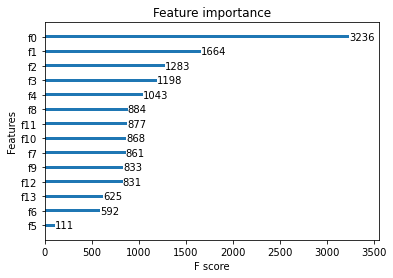

In [30]:
from xgboost import plot_importance
from matplotlib import pyplot as plt
# import graphviz
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# load data
dataset = pd.read_csv('datanew/artist_influence_music4_3.csv')
# split data into X and y
dataset.drop(['artist_name','artist_id'],axis=1,inplace=True)
X = dataset.iloc[:,1:]
X = X.values
Y = dataset.iloc[:,0]
Y = Y.values

# split data into train and test sets
seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

params ={'learning_rate': 0.4,
          'max_depth': 20,                # 构建树的深度，越大越容易过拟合
          'num_boost_round':2000,
          'objective': 'reg:squarederror',
          'random_state': 7,
          'silent':0,
          # 'num_class':2,                 # 类别数，与 multisoftmax 并用
          'eta':0.8,                      #为了防止过拟合，更新过程中用到的收缩步长。eta通过缩减特征 的权重使提升计算过程更加保守。缺省值为0.3，取值范围为：[0,1]
          # 'verbosity':0
        }
model = xgb.train(params,xgb.DMatrix(X_train, y_train))
y_pred = model.predict(xgb.DMatrix(X_test))

model.save_model('testXGboostClass.model')  # 保存训练模型

# yprob = np.argmax(y_pred, axis=1)  # return the index of the biggest pro

predictions = [round(value) for value in y_pred]

# evaluate predictions
mse = np.sqrt(mean_squared_error(y_test,predictions))
print('mse:', mse)

# 显示重要特征
plot_importance(model)
plt.grid(None)
fig=plt.gcf()
fig.savefig('./666.jpg')
# import graphviz
# import matplotlib.pyplot as plt
# xgb.plot_tree(model, num_trees = 0,rankdir = 'LR')
# plt.show()